In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams['figure.dpi'] = 150
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import numpy as np
import pandas as pd
import pickle

import os
import requests
from io import BytesIO
from io import StringIO

from astropy.table import Table
from astropy.table import join
from astropy.io import ascii
import astropy.constants as c

#from scipy import interpolate
#from sklearn import svm

# Function to get NASA Exoplanet Archive catalogs 
# from Dan Foreman-Mackey (https://github.com/dfm/exopop)
def get_catalog(name, basepath="../data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
        
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

#To track the provenance of different columns, we want a function to prepend an informative string to each column name.
#We will do this before merging tables to make tracking the information easier.
def prepend_dataframe_columns(df, prefix):
    df.columns = [prefix+col for col in df.columns]
    return 


#Suppressing astropy units warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#Suppressing Pandas chained assignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

# Kepler Q1-Q17 DR25 official catalog of planet candidates

In [2]:
dr25 = get_catalog('q1_q17_dr25_koi')
prepend_dataframe_columns(dr25, 'dr25_')
dr25.head()

,dr25_kepid,dr25_kepoi_name,dr25_kepler_name,dr25_ra,dr25_ra_err,dr25_ra_str,dr25_dec,dr25_dec_err,dr25_dec_str,dr25_koi_gmag,...,dr25_koi_fpflag_co,dr25_koi_fpflag_ec,dr25_koi_insol,dr25_koi_insol_err1,dr25_koi_insol_err2,dr25_koi_srho,dr25_koi_srho_err1,dr25_koi_srho_err2,dr25_koi_fittype,dr25_koi_score
0,10811496,K00753.01,NaN,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,0,0,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.0
1,10848459,K00754.01,NaN,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,0,0,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.0
2,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,0,0,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.0
3,10872983,K00756.01,Kepler-228 d,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,114.81,112.85,-36.70,0.67324,0.33286,-0.38858,LS+MCMC,1.0
4,10872983,K00756.02,Kepler-228 c,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,427.65,420.33,-136.70,0.37377,0.74768,-0.26357,LS+MCMC,1.0


In [3]:
dr25['multi_flag'] = np.zeros(len(dr25))

for i in range(len(dr25)):
    _kic = dr25['dr25_kepid'].iloc[i]
    _arg = dr25['dr25_kepid'] == _kic
    dr25['multi_flag'].iloc[i] = len(dr25['dr25_kepoi_name'][_arg])

# Berger et al. 2018 planet parameters

In [4]:
b18 = Table.read("http://cdsarc.unistra.fr/ftp/J/ApJ/866/99/table2.dat",
                   readme="http://cdsarc.unistra.fr/ftp/J/ApJ/866/99/ReadMe",
                   format="ascii.cds")

b18 = b18.to_pandas()
prepend_dataframe_columns(b18, 'b18_')
b18.head()

,b18_KIC,b18_KOI,b18_Rp,b18_E_Rp,b18_e_Rp,b18_Fp,b18_E_Fp,b18_e_Fp,b18_Bin
0,10797460,K00752.01,2.316,0.156,0.134,104.641,8.011,7.367,0
1,10797460,K00752.02,2.898,0.955,0.207,10.186,0.780,0.717,0
2,10854555,K00755.01,2.308,0.410,0.230,652.435,55.222,50.242,0
3,10872983,K00756.01,4.600,0.721,0.334,122.778,14.831,13.014,0
4,10872983,K00756.02,3.268,0.341,0.337,457.318,55.241,48.473,0


# Berger et al. 2020 planet parameters

In [5]:
b20 = Table.read("http://cdsarc.unistra.fr/ftp/J/AJ/160/108/table1.dat",
                 readme="http://cdsarc.unistra.fr/ftp/J/AJ/160/108/ReadMe",
                 format="ascii.cds")

b20 = b20.to_pandas()
prepend_dataframe_columns(b20, 'b20_')
b20['b20_KOI'] = ['K'+str(k).zfill(8) for k in b20['b20_KOI']]
b20.head()

,b20_KIC,b20_KOI,b20_PD,b20_Radius,b20_E_Radius,b20_e_Radius,b20_a,b20_E_a,b20_e_a,b20_Flux,b20_E_Flux,b20_e_Flux,b20_ZAMSFlux,b20_Flag
0,11446443,K00001.01,CONFIRMED,14.21,0.29,0.29,0.0355,0.0008,0.0008,854.78,69.34,64.81,524.75,AO
1,10666592,K00002.01,CONFIRMED,16.45,0.35,0.34,0.0381,0.0005,0.0006,4285.95,331.23,336.99,2394.68,AO
2,10748390,K00003.01,CONFIRMED,4.88,0.08,0.07,0.0516,0.0006,0.0004,86.58,5.24,4.73,58.22,NaN
3,3861595,K00004.01,CONFIRMED,13.18,0.42,0.82,0.0583,0.0007,0.0015,5244.42,478.90,520.46,3647.63,AO
4,11853905,K00007.01,CONFIRMED,4.01,0.10,0.10,0.0455,0.0007,0.0010,1247.17,99.09,99.02,719.80,NaN


# Berger et al. 2020 stellar parameters

In [6]:
b20_t2 = pd.read_parquet('./data/GKSPCPapTable2.parquet')

b20 = b20.merge(b20_t2, 
                how='left',
                left_on='b20_KIC',
                right_on='b20_KIC')

b20.head()

,b20_KIC,b20_KOI,b20_PD,b20_Radius,b20_E_Radius,b20_e_Radius,b20_a,b20_E_a,b20_e_a,b20_Flux,...,b20_iso_age_err2,b20_iso_dis,b20_iso_dis_err1,b20_iso_dis_err2,b20_iso_avs,b20_iso_gof,b20_TAMS,b20_log10_iso_age,b20_E_log10_iso_age,b20_e_log10_iso_age
0,11446443,K00001.01,CONFIRMED,14.21,0.29,0.29,0.0355,0.0008,0.0008,854.78,...,-3.22,214.8,3.8,-3.7,0.000,1.0000,10.93,9.790285,0.202268,0.320463
1,10666592,K00002.01,CONFIRMED,16.45,0.35,0.34,0.0381,0.0005,0.0006,4285.95,...,-0.38,340.2,5.8,-6.2,0.262,1.0000,2.68,9.240549,0.087830,0.107010
2,10748390,K00003.01,CONFIRMED,4.88,0.08,0.07,0.0516,0.0006,0.0004,86.58,...,-5.58,37.3,0.6,-0.6,0.000,1.0000,32.98,10.190332,0.078246,0.193820
3,3861595,K00004.01,CONFIRMED,13.18,0.42,0.82,0.0583,0.0007,0.0015,5244.42,...,-0.11,782.4,22.3,-21.6,0.433,0.9915,1.42,9.079181,0.091080,0.041755
4,11853905,K00007.01,CONFIRMED,4.01,0.10,0.10,0.0455,0.0007,0.0010,1247.17,...,-1.01,485.7,10.9,-9.8,0.124,1.0000,5.32,9.594393,0.164519,0.129010


In [7]:
#CKS VII stellar parameters table
cks_t2 = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/AJ/156/264/table2.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/AJ/156/264/ReadMe",
                 format="ascii.cds")

#CKS VII planet parameters table
cks_t3 = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/AJ/156/264/table3.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/AJ/156/264/ReadMe",
                 format="ascii.cds")

cks_t3['KOI_star'] = [k.split(".")[0] for k in cks_t3['KOI']]


cks_t2 = cks_t2.to_pandas()
cks_t3 = cks_t3.to_pandas()
cks_t2 = cks_t2.rename(columns={"KOI": "KOI_star"})

cks = cks_t3.merge(cks_t2, how='left', left_on='KOI_star', right_on='KOI_star')

prepend_dataframe_columns(cks, 'cks_')

cks.head()

,cks_KOI,cks_Per,cks_E_Per,cks_e_Per,cks_Rp/R*,cks_E_Rp/R*,cks_e_Rp/R*,cks_Rp,cks_E_Rp,cks_e_Rp,...,cks_E_rhoiso,cks_e_rhoiso,cks_logAiso,cks_E_logAiso,cks_e_logAiso,cks_plxspec,cks_E_plxspec,cks_e_plxspec,cks_r8,cks_RCF
0,K00001.01,2.470613,1.900000e-08,1.900000e-08,0.123851,0.000025,0.000076,14.141,0.331,0.331,...,0.04,0.04,9.74,0.13,0.15,4.756,0.320,0.474,1.000,1.0102
1,K00002.01,2.204735,3.800000e-08,3.800000e-08,0.075408,0.000008,0.000007,16.250,0.349,0.349,...,0.01,0.00,9.25,0.04,0.05,3.661,0.411,0.586,1.001,1.0034
2,K00006.01,1.334104,7.070000e-07,7.070000e-07,0.294016,0.103683,0.209459,41.936,22.239,22.239,...,0.03,0.03,9.32,0.09,0.24,2.201,0.127,0.212,1.007,1.0006
3,K00007.01,3.213669,1.122000e-06,1.122000e-06,0.024735,0.000141,0.000076,4.076,0.107,0.107,...,0.02,0.02,9.78,0.09,0.08,2.112,0.228,0.274,1.000,NaN
4,K00008.01,1.160153,4.270000e-07,4.270000e-07,0.018559,0.000246,0.001678,1.896,0.110,0.110,...,0.03,0.05,9.18,0.26,0.52,2.895,0.127,0.192,1.001,NaN


# Merge the DR25 dataframe with the GKSPC and CKS catalogs

In [8]:
dr25 = dr25.merge(b20, 
                  how='left', 
                  left_on='dr25_kepoi_name',
                  right_on='b20_KOI')

dr25 = dr25.merge(b18, 
                  how='left', 
                  left_on='dr25_kepoi_name',
                  right_on='b18_KOI')

dr25 = dr25.merge(cks, 
                  how='left', 
                  left_on='dr25_kepoi_name',
                  right_on='cks_KOI')

# Sample selection

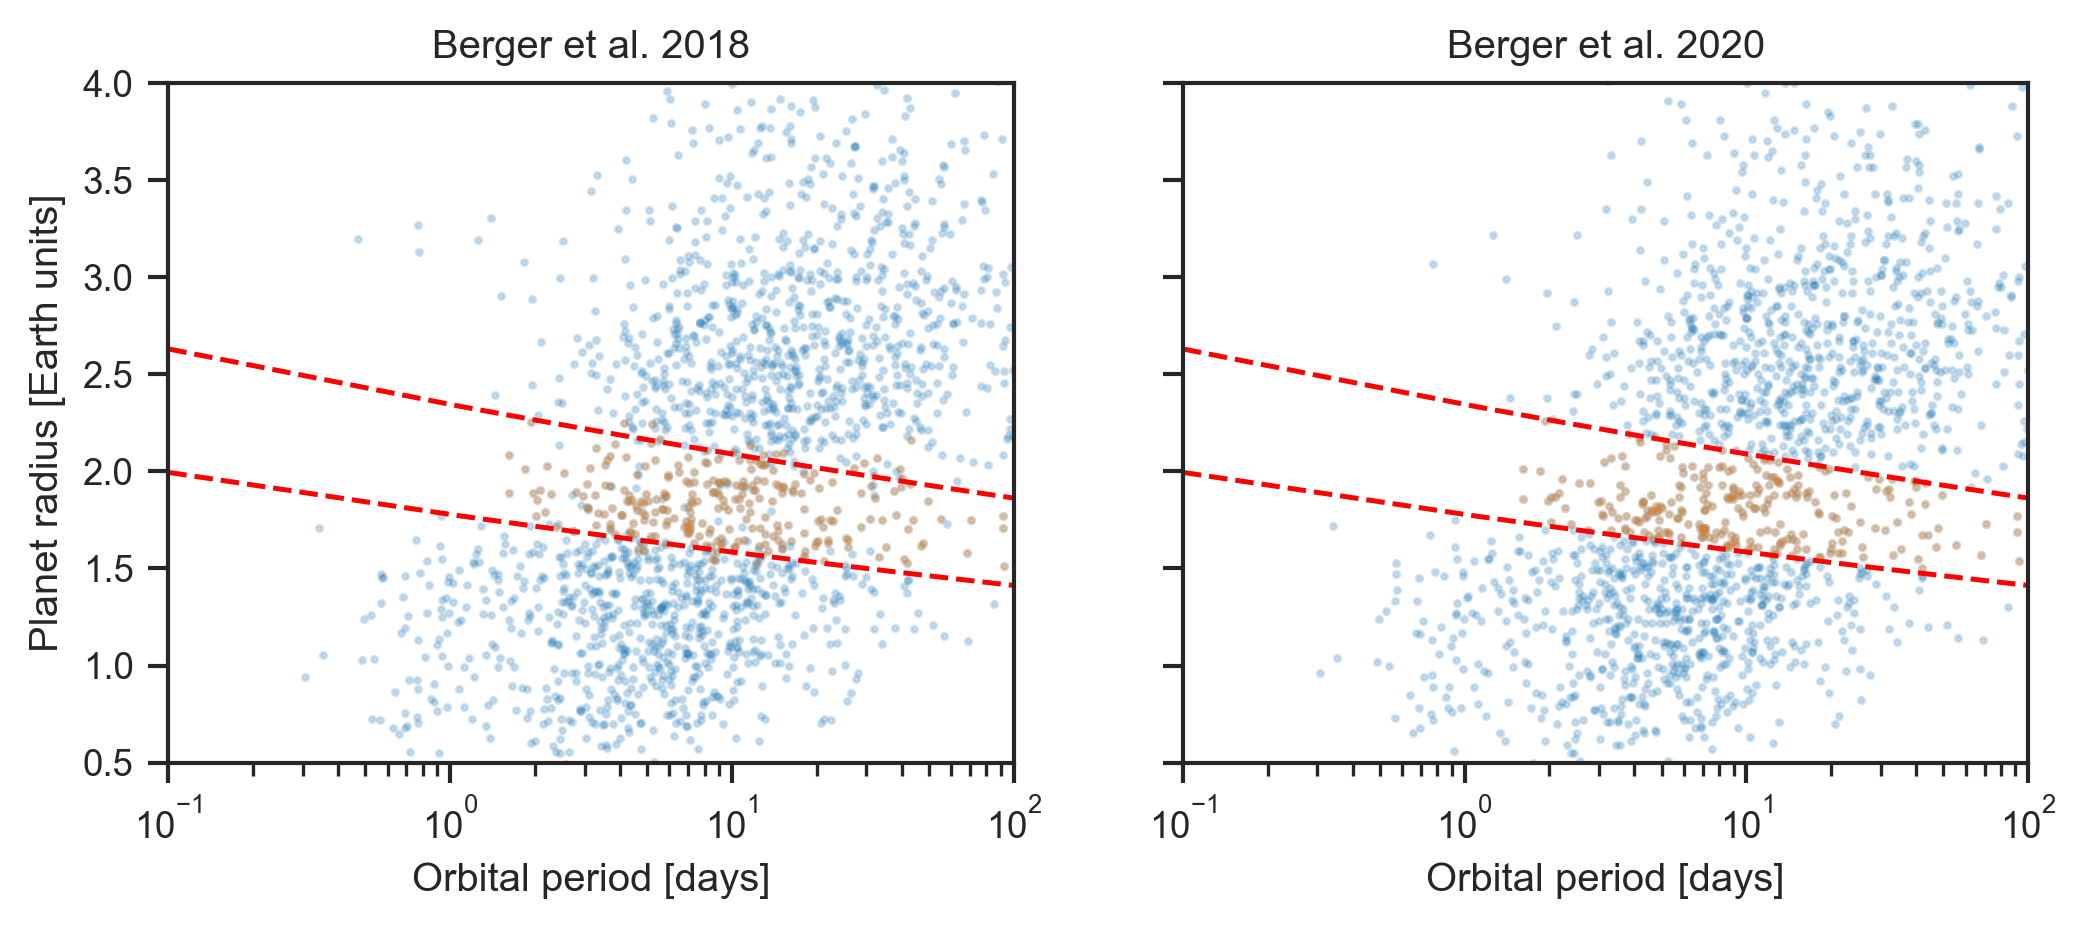

In [9]:
def radius_gap(period,
               alpha=-0.05,
               beta=0.31,
               gamma=0.06):
    
    center = alpha*np.log10(period) + beta
    upper  = 10.**(center + gamma*np.sqrt(1.0+alpha**2.))
    lower  = 10.**(center - gamma*np.sqrt(1.0+alpha**2.))
    
    return upper, lower


#For plotting purposes
pgap = np.linspace(0.1,1000,1000)
rgap_hi, rgap_lo = radius_gap(pgap)


arg = (dr25.dr25_koi_score>0.95)
arg &= (dr25.dr25_koi_disposition!='FALSE POSITIVE')
arg &= (dr25.dr25_koi_period<100)
arg &= (dr25.dr25_koi_gmag<16)

in_the_gap = arg & (dr25.b20_Radius < radius_gap(dr25.dr25_koi_period)[0]) & (dr25.b20_Radius > radius_gap(dr25.dr25_koi_period)[1])

sc_kwargs = {"alpha":0.2, "s":2}

fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(8,3),sharex=True,sharey=True)

ax1.scatter(dr25.dr25_koi_period[arg], dr25.b18_Rp[arg], **sc_kwargs)
ax1.scatter(dr25.dr25_koi_period[in_the_gap], dr25.b18_Rp[in_the_gap], **sc_kwargs)
ax1.plot(pgap, rgap_hi, 'r--')
ax1.plot(pgap, rgap_lo, 'r--')

ax1.semilogx()
ax1.set_title('Berger et al. 2018')
ax1.set_ylim(0.5,4)
ax1.set_xlim(0.1,100)
ax1.set_xlabel('Orbital period [days]')
ax1.set_ylabel('Planet radius [Earth units]')

ax2.semilogx()
ax2.set_title('Berger et al. 2020')
ax2.scatter(dr25.dr25_koi_period[arg], dr25.b20_Radius[arg], **sc_kwargs)
ax2.scatter(dr25.dr25_koi_period[in_the_gap], dr25.b20_Radius[in_the_gap], **sc_kwargs)
ax2.plot(pgap, rgap_hi, 'r--')
ax2.plot(pgap, rgap_lo, 'r--')

ax2.set_xlabel('Orbital period [days]')

plt.show()

In [16]:
df = dr25[in_the_gap]
df.head()

,dr25_kepid,dr25_kepoi_name,dr25_kepler_name,dr25_ra,dr25_ra_err,dr25_ra_str,dr25_dec,dr25_dec_err,dr25_dec_str,dr25_koi_gmag,...,cks_E_rhoiso,cks_e_rhoiso,cks_logAiso,cks_E_logAiso,cks_e_logAiso,cks_plxspec,cks_E_plxspec,cks_e_plxspec,cks_r8,cks_RCF
10,5436502,K00834.04,Kepler-238 b,287.89713,0.0,19h11m35.31s,40.637821,0.0,+40d38m16.2s,15.600,...,0.04,0.03,9.68,0.12,0.06,0.563,0.069,0.078,1.000,NaN
157,10928043,K01315.01,NaN,295.29385,0.0,19h41m10.52s,48.374802,0.0,+48d22m29.3s,13.463,...,0.02,0.03,9.52,0.12,0.14,1.595,0.133,0.206,1.000,1.0079
158,10794087,K01316.01,NaN,290.55237,0.0,19h22m12.57s,48.126263,0.0,+48d07m34.5s,12.474,...,0.01,0.02,9.57,0.14,0.04,1.894,0.236,0.253,1.003,1.0085
176,4466677,K01338.02,NaN,292.27612,0.0,19h29m06.27s,39.550179,0.0,+39d33m00.6s,15.129,...,0.07,0.07,9.97,0.09,0.13,1.177,0.095,0.126,1.054,NaN
200,9579641,K00115.02,Kepler-105 c,287.88733,0.0,19h11m32.96s,46.276241,0.0,+46d16m34.5s,13.111,...,0.06,0.06,9.63,0.14,0.20,2.202,0.147,0.212,1.004,1.0002


In [17]:
df.to_csv('./data/sample.csv')

In [18]:
for col in df.columns:
    print(col)

dr25_kepid
dr25_kepoi_name
dr25_kepler_name
dr25_ra
dr25_ra_err
dr25_ra_str
dr25_dec
dr25_dec_err
dr25_dec_str
dr25_koi_gmag
dr25_koi_gmag_err
dr25_koi_rmag
dr25_koi_rmag_err
dr25_koi_imag
dr25_koi_imag_err
dr25_koi_zmag
dr25_koi_zmag_err
dr25_koi_jmag
dr25_koi_jmag_err
dr25_koi_hmag
dr25_koi_hmag_err
dr25_koi_kmag
dr25_koi_kmag_err
dr25_koi_kepmag
dr25_koi_kepmag_err
dr25_koi_delivname
dr25_koi_vet_stat
dr25_koi_quarters
dr25_koi_disposition
dr25_koi_pdisposition
dr25_koi_count
dr25_koi_num_transits
dr25_koi_max_sngle_ev
dr25_koi_max_mult_ev
dr25_koi_bin_oedp_sig
dr25_koi_limbdark_mod
dr25_koi_ldm_coeff4
dr25_koi_ldm_coeff3
dr25_koi_ldm_coeff2
dr25_koi_ldm_coeff1
dr25_koi_trans_mod
dr25_koi_model_snr
dr25_koi_model_dof
dr25_koi_model_chisq
dr25_koi_time0bk
dr25_koi_time0bk_err1
dr25_koi_time0bk_err2
dr25_koi_eccen
dr25_koi_eccen_err1
dr25_koi_eccen_err2
dr25_koi_longp
dr25_koi_longp_err1
dr25_koi_longp_err2
dr25_koi_prad
dr25_koi_prad_err1
dr25_koi_prad_err2
dr25_koi_sma
dr25_koi_sma_

In [386]:
for i in range(len(dr25)):
    if dr25['dr25_kepid'].iloc[i] == 11512246:
        print(dr25['dr25_kepid'].iloc[i], dr25['dr25_koi_period'].iloc[i], dr25['dr25_koi_ror'].iloc[i], dr25['dr25_koi_ror_err1'].iloc[i], dr25['dr25_koi_ror_err2'].iloc[i],
             dr25['dr25_koi_impact'].iloc[i], dr25['dr25_koi_impact_err1'].iloc[i], dr25['dr25_koi_impact_err2'].iloc[i], dr25['b20_iso_rad'].iloc[i])

11512246 10.74241765 0.018486 0.000251 -0.000102 0.034 0.257 -0.034 1.504
11512246 15.27443889 0.013073 0.000332 -0.000232 0.153 0.227 -0.153 1.504
11512246 7.10695741 0.01039 0.000332 -0.000158 0.079 0.32 -0.079 1.504


In [385]:
for col in dr25.columns:
    print(col)

dr25_kepid
dr25_kepoi_name
dr25_kepler_name
dr25_ra
dr25_ra_err
dr25_ra_str
dr25_dec
dr25_dec_err
dr25_dec_str
dr25_koi_gmag
dr25_koi_gmag_err
dr25_koi_rmag
dr25_koi_rmag_err
dr25_koi_imag
dr25_koi_imag_err
dr25_koi_zmag
dr25_koi_zmag_err
dr25_koi_jmag
dr25_koi_jmag_err
dr25_koi_hmag
dr25_koi_hmag_err
dr25_koi_kmag
dr25_koi_kmag_err
dr25_koi_kepmag
dr25_koi_kepmag_err
dr25_koi_delivname
dr25_koi_vet_stat
dr25_koi_quarters
dr25_koi_disposition
dr25_koi_pdisposition
dr25_koi_count
dr25_koi_num_transits
dr25_koi_max_sngle_ev
dr25_koi_max_mult_ev
dr25_koi_bin_oedp_sig
dr25_koi_limbdark_mod
dr25_koi_ldm_coeff4
dr25_koi_ldm_coeff3
dr25_koi_ldm_coeff2
dr25_koi_ldm_coeff1
dr25_koi_trans_mod
dr25_koi_model_snr
dr25_koi_model_dof
dr25_koi_model_chisq
dr25_koi_time0bk
dr25_koi_time0bk_err1
dr25_koi_time0bk_err2
dr25_koi_eccen
dr25_koi_eccen_err1
dr25_koi_eccen_err2
dr25_koi_longp
dr25_koi_longp_err1
dr25_koi_longp_err2
dr25_koi_prad
dr25_koi_prad_err1
dr25_koi_prad_err2
dr25_koi_sma
dr25_koi_sma_

In [359]:
for i in range(len(df)):
    print(df['dr25_kepid'].iloc[i])

9818381
11180361
10666592
8359498
11359879
6448890
11974540
7778437
10874614
7877496
4570949
11046458
9410930
3861595
9631995
5728139
9651668
11017901
6046540
7950644
10028352
7215678
7017372
7051180
4252322
9478990
6509282
4282390
5033823
10418224
12307496
11282568
5441980
6309763
7368664
5780885
5443837
6956176
4742414
9846348
6922244
7277317
7529266


In [215]:
import lightkurve as lk
print('lightkurve version', lk.__version__)

lightkurve version 2.0.10


In [349]:
idx = np.random.choice(len(df))

_kic = df.dr25_kepid.iloc[idx]
_period = df.dr25_koi_period.iloc[idx]
_t0 = df.dr25_koi_time0.iloc[idx] - 2454833.0
_mstar = df.b20_iso_mass.iloc[idx]
_mstar_err1 = df.b20_iso_mass_err1.iloc[idx]
_mstar_err2 = df.b20_iso_mass_err2.iloc[idx]
_rstar = df.b20_iso_rad.iloc[idx]
_rstar_err1 = df.b20_iso_rad_err1.iloc[idx]
_rstar_err2 = df.b20_iso_rad_err2.iloc[idx]

period_guess = df.dr25_koi_period.iloc[idx]
depth_guess  = df.dr25_koi_depth.iloc[idx]*1e-3
t0_guess     = df.dr25_koi_time0.iloc[idx] - 2454833.0

print(_kic, _period, depth_guess, _t0, _mstar, _rstar)

11046458 3.311864148 5.9765 131.74299999978393 1.018 1.047


In [350]:
try:
    result = lk.search_lightcurve("KIC "+str(_kic), author="Kepler", cadence="short")
    lc_collection = result.download_all()
    print(lc_collection)
except:
    pass

LightCurveCollection of 21 objects:
    0: <KeplerLightCurve LABEL="KIC 11046458" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    1: <KeplerLightCurve LABEL="KIC 11046458" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    2: <KeplerLightCurve LABEL="KIC 11046458" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    3: <KeplerLightCurve LABEL="KIC 11046458" QUARTER=5 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    4: <KeplerLightCurve LABEL="KIC 11046458" QUARTER=5 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    5: <KeplerLightCurve LABEL="KIC 11046458" QUARTER=5 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    6: <KeplerLightCurve LABEL="KIC 11046458" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    7: <KeplerLightCurve LABEL="KIC 11046458" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    8: <KeplerLightCurve LABEL="KIC 11046458" QUARTER=6 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    9: <KeplerLightCurve LABEL="KIC 11046458" QUARTER=8 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>
    10: <Keple

In [221]:
# # Create a larger figure for clarity
# fig, ax = plt.subplots(figsize=(20,5))
# # Plot the light curve collection
# lc_collection.plot(ax=ax);

In [315]:
lc_collection[0].columns

<TableColumns names=('time','flux','flux_err','quality','timecorr','centroid_col','centroid_row','cadenceno','sap_flux','sap_flux_err','sap_bkg','sap_bkg_err','pdcsap_flux','pdcsap_flux_err','sap_quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2')>

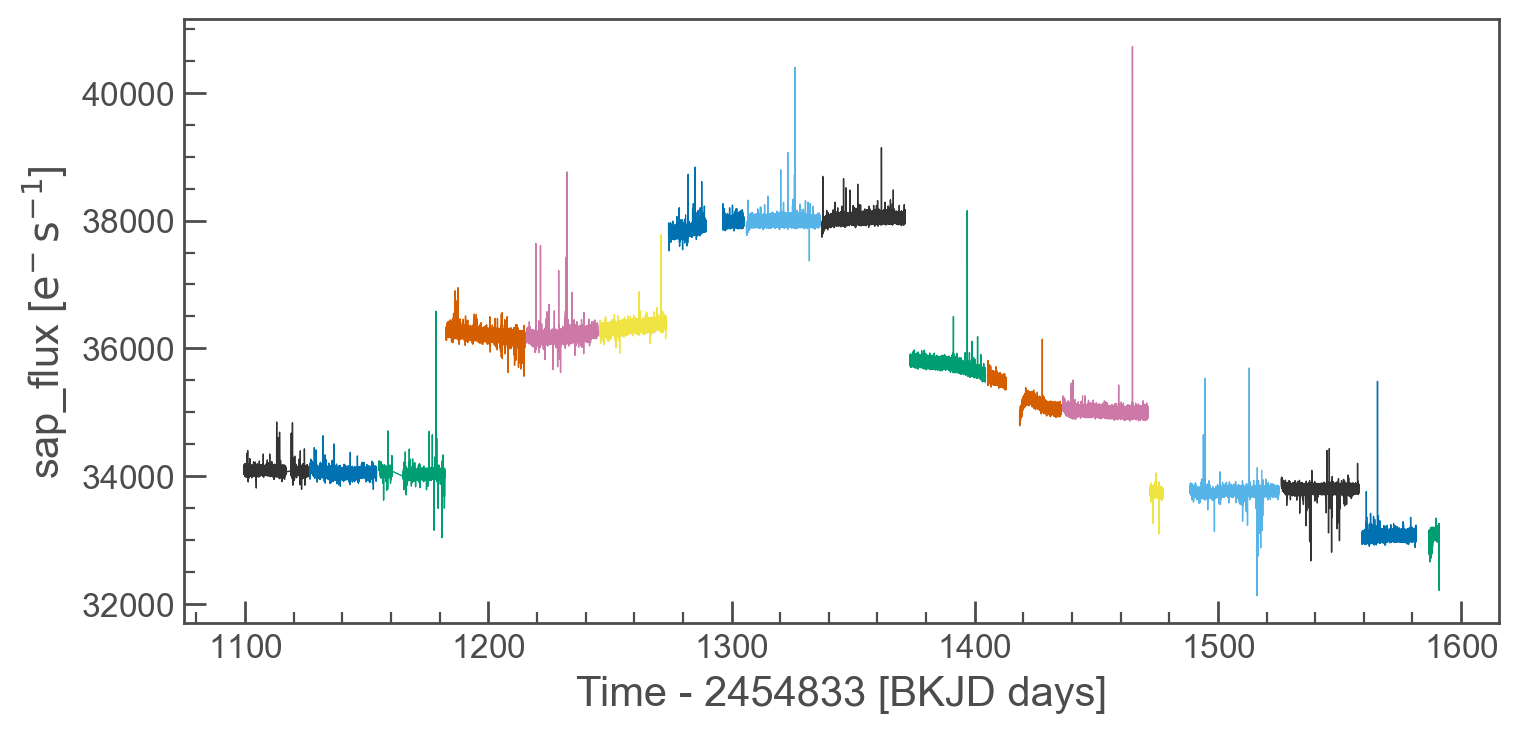

In [345]:
# ax = lc_collection[0].plot(column='sap_flux', label=None)
# for lc in lc_collection[1:]:
#     lc.plot(ax=ax, column='sap_flux', label=None)

In [351]:
lc_stitched = lc_collection.stitch()

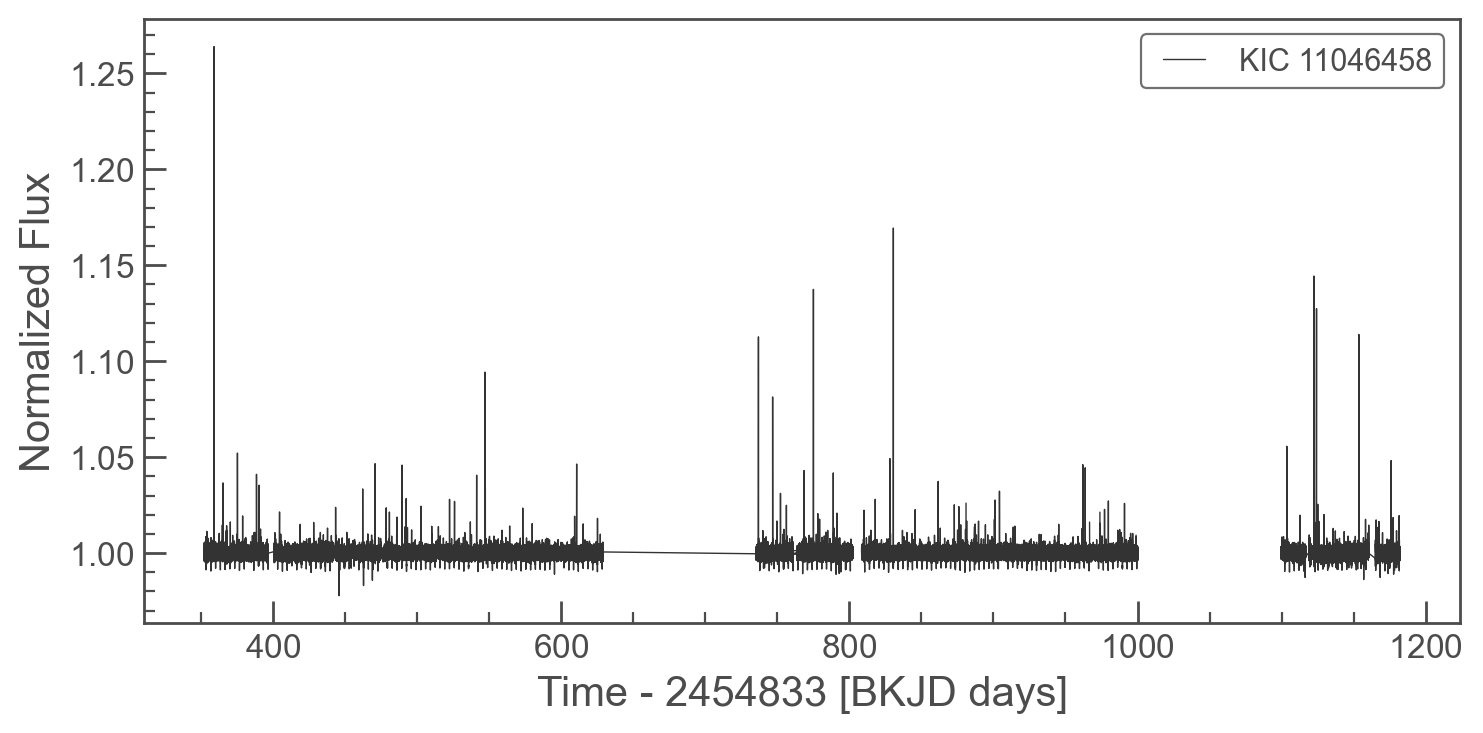

In [352]:
lc_stitched.plot();

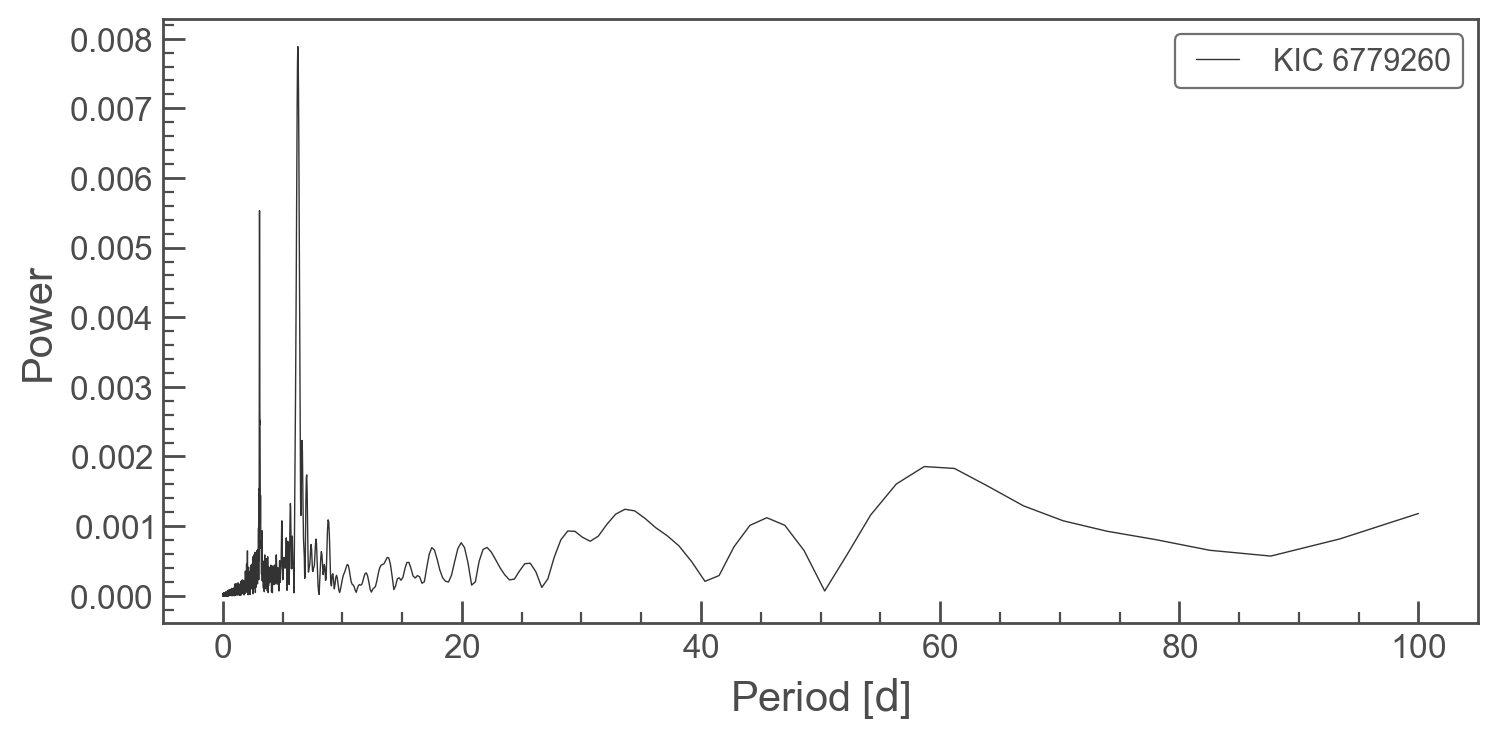

In [238]:
pg = lc_stitched.to_periodogram(maximum_period=100)
pg.plot(view='period');

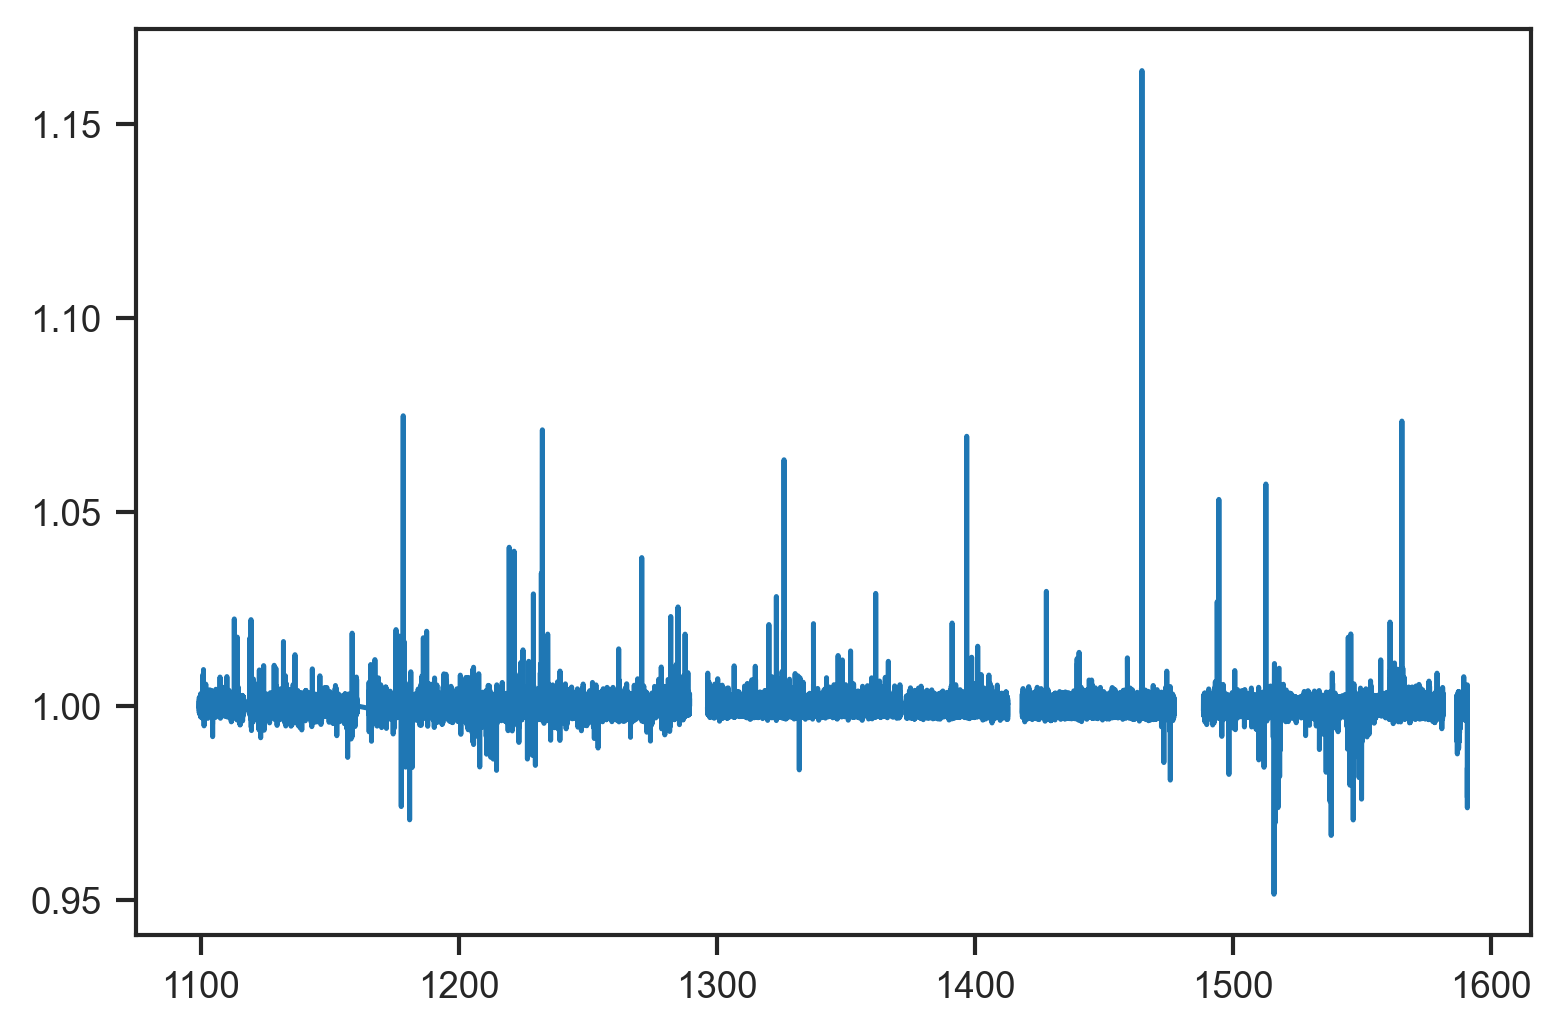

In [343]:
plt.plot(lc_stitched.time.value, lc_stitched.flux)

In [245]:
#lc_stitched = lc_stitched.flatten(window_length=2001)
#lc_stitched.plot()

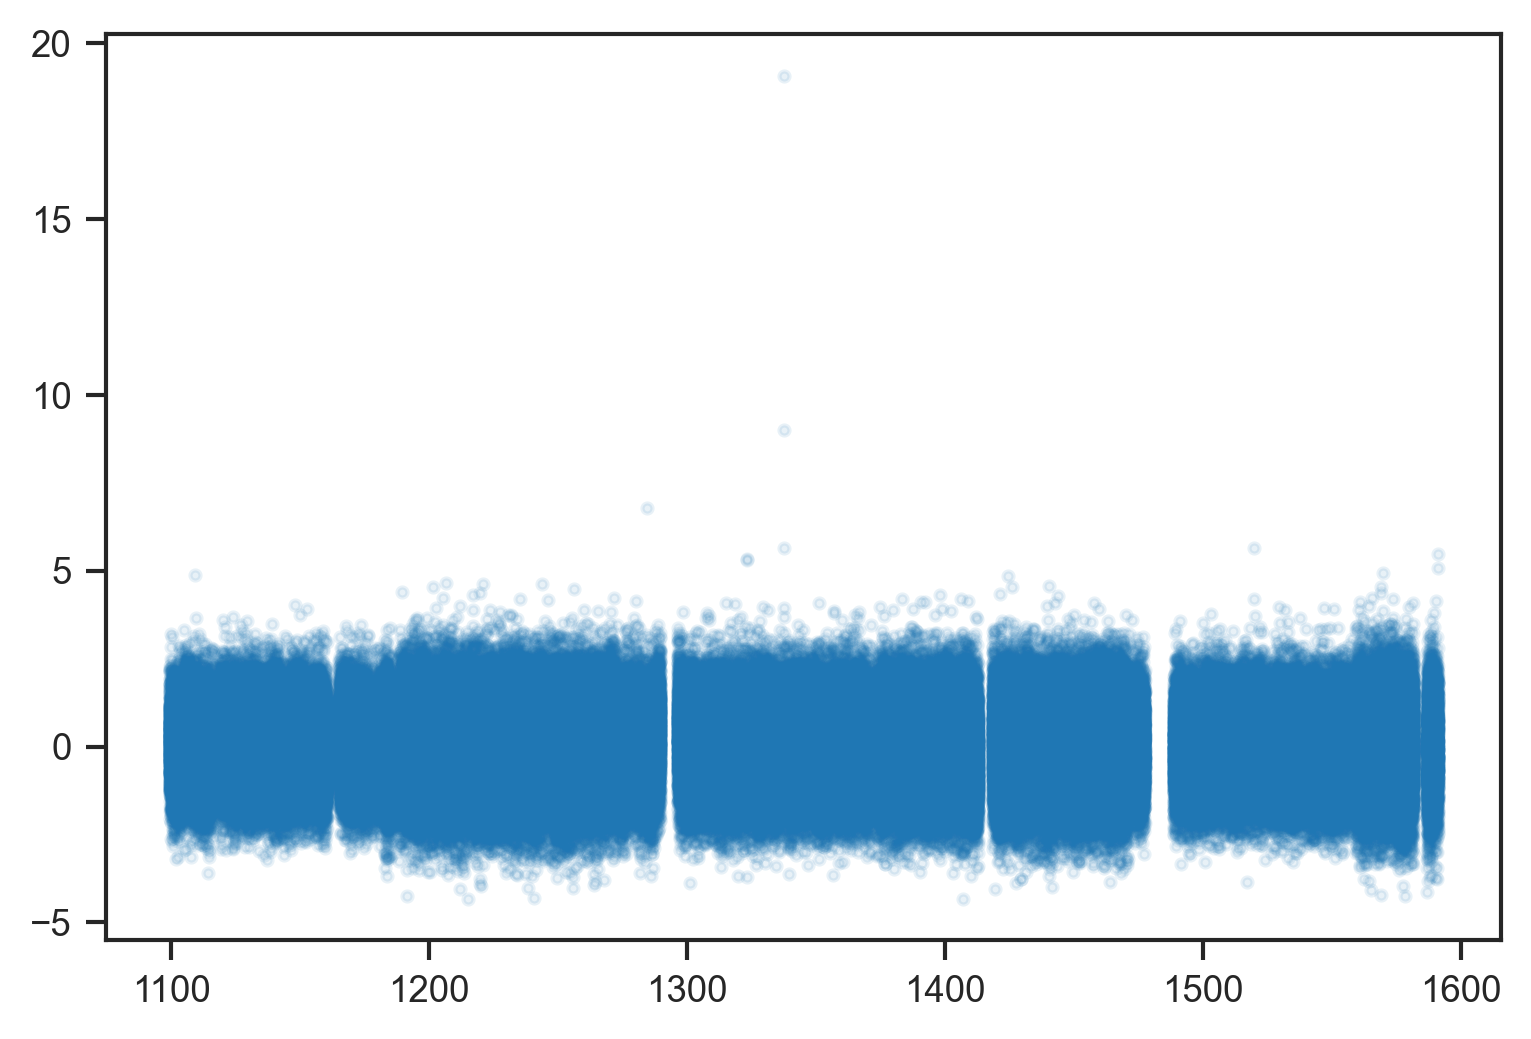

In [344]:
# Data points with nonzero quality flags have some issues that means the measurements may be less reliable.
# We will select only data where the quality flag is equal to zero (indicating good data quality).
# We also select data only where time and flux values exist.
good_data = (lc_stitched.quality == 0) & (np.isfinite(lc_stitched.time.value)) & (np.isfinite(lc_stitched.flux))

time = lc_stitched.time.value[good_data]
flux = lc_stitched.flux[good_data]
flux_err  = lc_stitched.flux_err[good_data]

# We will normalize the flux about zero and multiply by 1000 to put the light curve in units of parts-per-thousand (ppt)
# We similarly multiply the flux errors by 1000 to put them in units of ppt.
flux = (flux - 1.0) * 1e3
flux_err = flux_err * 1e3

plt.plot(time, flux, '.', alpha=0.1)
plt.show()